In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt


Bad key "text.kerning_factor" on line 4 in
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


### Question 1

In [2]:
gotv = pd.read_excel('gotv_individual.xlsx')

In [3]:
gotv.head()

,treatment,hh_id,hh_size,sex,yob,g2000,g2002,g2004,p2000,p2002,p2004,p2004_mean,g2004_mean,voted
0,Civic Duty,1.0,2,male,1941,1,1,1,0,1,0,0.095238,0.857143,0
1,Civic Duty,1.0,2,female,1947,1,1,1,0,1,0,0.095238,0.857143,0
2,Hawthorne,2.0,3,male,1951,1,1,1,0,1,0,0.047619,0.857143,1
3,Hawthorne,2.0,3,female,1950,1,1,1,0,1,0,0.047619,0.857143,1
4,Hawthorne,2.0,3,female,1982,1,1,1,0,1,0,0.047619,0.857143,1


In [4]:
gotv = gotv.assign(sex_binary=gotv.sex.map({'male': 0, 'female': 1}))

In [5]:
gotv = gotv.assign(age=2006-gotv.yob)

In [6]:
num_var = ['hh_size', 'g2000', 'g2002', 'g2004', 'p2000', 'p2002', 'p2004', 'voted', 'sex_binary', 'age']
cat_var = ['treatment']
transformations = {v: 'mean' for v in num_var}
transformations.update({v: pd.Series.mode for v in cat_var})
gotv_house = gotv.groupby('hh_id').agg(transformations)
gotv_house.head()

,hh_size,g2000,g2002,g2004,p2000,p2002,p2004,voted,sex_binary,age,treatment
hh_id,,,,,,,,,,,
1.0,2,1.000000,1.000000,1,0.0,1.000000,0.0,0.000000,0.500000,62.000000,Civic Duty
2.0,3,1.000000,1.000000,1,0.0,1.000000,0.0,1.000000,0.666667,45.000000,Hawthorne
3.0,3,0.666667,0.666667,1,0.0,0.666667,0.0,0.666667,0.333333,40.666667,Control
4.0,2,0.500000,0.500000,1,0.0,1.000000,0.0,0.000000,0.500000,38.500000,Control
5.0,1,1.000000,1.000000,1,0.0,0.000000,1.0,1.000000,0.000000,65.000000,Control


The authors work at the household level, because the individual level poses some issues:
1. For individual level, we can't determine who reads the mailer. 
2. Household member may affect each other.

### Question 2

In [7]:
covariates_to_check = ['g2000', 'g2002', 'p2000', 'p2002', 'p2004', 'sex_binary', 'age']
gotv_house.groupby('treatment')[covariates_to_check].mean()

,g2000,g2002,p2000,p2002,p2004,sex_binary,age
treatment,,,,,,,
Civic Duty,0.865388,0.836149,0.266413,0.409875,0.415508,0.502696,51.178998
Control,0.866309,0.834383,0.264894,0.408667,0.416634,0.502263,51.313998
Hawthorne,0.866766,0.835654,0.263210,0.411651,0.418783,0.503219,51.204121
Neighbors,0.865250,0.835149,0.263134,0.405962,0.422652,0.504600,51.342334
Self,0.862548,0.835222,0.262901,0.410353,0.420857,0.501356,51.244210


The means are similar across groups. The results showed no violation of randomization and ignorability, but it's not sufficient to say that randomization and ignorability are satisfied, those are "metadata" and can't be inferred from the data.

### Question 3

In [8]:
potential_treatments = list(gotv_house.treatment.unique())
potential_treatments.remove(' Control')
res_dict = {}
for t in potential_treatments:
    df = gotv_house[gotv_house.treatment==t]
    res_dict[t] = df.voted.mean() - df.voted.mean()

In [9]:
res_df = pd.DataFrame.from_dict(res_dict, orient='index', columns=['ate'])
res_df

,ate
Civic Duty,0.0
Hawthorne,0.0
Self,0.0
Neighbors,0.0


We are assuming SUTVA (same treatment version for each treatment, and no interaction between households), as well as ignorability and positivity from the randomization.

### Question 4

In [10]:
control = gotv_house[gotv_house.treatment==' Control']
neighbors = gotv_house[gotv_house.treatment==' Neighbors']

var_ate = neighbors.voted.var() / len(neighbors) + control.voted.var() / len(control)

tau = neighbors.voted.mean() - control.voted.mean()
print(tau)

Zn = tau / np.sqrt(var_ate)
pval = sps.norm.sf(np.abs(Zn))*2

print('statistic', Zn, 'pvalue', pval)

0.08478807597718824
statistic 24.928663034824016 pvalue 3.638694708277031e-137


The p-value is very small

### Question 5

In [11]:
gotv_neighbors_control = gotv_house[gotv_house.treatment.isin([' Control', ' Neighbors'])]
N = len(gotv_neighbors_control)
rg = np.random.default_rng(125)
N_iter = 1000
all_Zs = np.empty(N_iter)
for i in range(N_iter):
    # assigns treatment to N units, each unit has the same prob of receiving treatment
    gotv_neighbors_control = gotv_neighbors_control.assign(
      T_permute = rg.permutation(gotv_neighbors_control.treatment))
    perm_gotv_1 = gotv_neighbors_control[gotv_neighbors_control.T_permute==' Neighbors'].voted
    perm_gotv_0 = gotv_neighbors_control[gotv_neighbors_control.T_permute==' Control'].voted
    all_Zs[i] = (perm_gotv_1.mean() - perm_gotv_0.mean())/np.sqrt(perm_gotv_1.var()/len(perm_gotv_1) + perm_gotv_0.var()/len(perm_gotv_0))

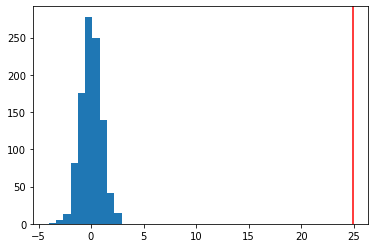

In [12]:
h = plt.hist(all_Zs)
plt.axvline(Zn, color='red')

### Question 6


In [13]:
# pvalue
np.sum(np.abs(all_Zs)>np.abs(Zn))/N_iter

0.0

p-values in both settings are close and very small. In randomization inference, when all possible assignments can be generated and we are assuming the same distribution as the asymptotical distribution, the p-value is the same as the asymptotical p-value. 